In [1]:
import simi

import pandas as pd
from sentence_transformers import evaluation, losses, models, InputExample, SentenceTransformer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, BertForMaskedLM, AutoModelForMaskedLM, AutoModel

from tqdm.auto import tqdm
tqdm.pandas()

RANDOM_STATE = 1

#set_seed(RANDOM_STATE)
#enable_full_determinism(RANDOM_STATE)


# SentenceTransformers cosine-similarity scoring for (m)class
def st_similarity_scoring(df, model, append=False, name="cos-sim"):
    scores = df.progress_apply(lambda r: simi.pairwise_cosine_similarity(simi.model_embeddings(model, [r["title_a"], r["title_b"]]))[0][0], axis=1)
    scores = pd.Series(scores, index=df.index, name=name)
    if append:
        return df.merge(scores.to_frame(), left_index=True, right_index=True)
    return scores

2024-01-07 11:11:05.137868: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load and select test data

In [2]:
df = pd.read_csv("class-zbmath-dataset.csv", index_col=0)
df.sample(5)

,title_a,MSC_a,MSC2_a,title_b,MSC_b,MSC2_b,label
377688,On deformations of the filiform Lie superalgeb...,17B30,"('17B56',)",Adjoint and trivial cohomologies of nilpotent ...,17B30,"('17B56', '17-04')",1
106370,Modelling volumetric growth in a thick walled ...,74L15,"('74A40', '74E10', '74S05')",The wrinkling of thin membranes. II. Numerical...,74L15,"('74B20', '74S05', '74K15', '74R99')",1
133137,All possible regressions with less computation,62J05,"('62J99',)",Regression models for ordinal data,62J05,"('62J99', '62H17')",1
37593,Monte Carlo method for the Lamé equation,74S30,"('74B05', '65C05')",A complex variable boundary collocation method...,74S30,"('74B05',)",1
421447,State constraints in impulsive control problem...,49N25,"('49K15', '49J15', '34K35')",Local Hölder continuity of the isoperimetric p...,49Q20,"('58E99', '53A10', '49Q05')",0


In [3]:
X_treval, X_test = train_test_split(df, train_size=0.9, random_state=RANDOM_STATE)
X_train, X_eval = train_test_split(X_treval, train_size=0.888889, random_state=RANDOM_STATE)
print("train:", len(X_train), "eval:", len(X_eval), "test:", len(X_test))

train: 351472 eval: 43935 test: 43935


## Model definitions

In [4]:
# Prerequisites for the models
bert_base = models.Transformer('bert-base-uncased')
mathbert_base = models.Transformer('witiko/mathberta')
#bert_finetune_base = models.Transformer("./bert+fine-tune_classi_class_zbmath", tokenizer_name_or_path="bert-base-uncased")
bert_mlm_base = models.Transformer("./bert+re-train_mlm_abstracts_arxiv")
specter2_base = models.Transformer('allenai/specter2_base')

# Definition of models that are evaluated
# combine models into dict
eval_models = {
    "Bert+CLS": SentenceTransformer(modules=[bert_base, models.Pooling(bert_base.get_word_embedding_dimension(), pooling_mode="cls")]),
    "Bert+MP": SentenceTransformer(modules=[bert_base, models.Pooling(bert_base.get_word_embedding_dimension())]),
    
    "SBert-MpNet": SentenceTransformer('all-mpnet-base-v2'),
    "SBert-DistilRoberta": SentenceTransformer('all-distilroberta-v1'),
    "SBert-MiniLM-L12": SentenceTransformer('all-MiniLM-L12-v2'),
    "SBert-MiniLM-L6": SentenceTransformer('all-MiniLM-L6-v2'),
    
    "Mathbert+CLS": SentenceTransformer(modules=[mathbert_base, models.Pooling(mathbert_base.get_word_embedding_dimension(), pooling_mode="cls")]),
    "Mathbert+MP": SentenceTransformer(modules=[mathbert_base, models.Pooling(mathbert_base.get_word_embedding_dimension())]),
    
    "Specter 2+CLS": SentenceTransformer(modules=[specter2_base, models.Pooling(specter2_base.get_word_embedding_dimension(), pooling_mode="cls")]),
    "Specter 2+MP": SentenceTransformer(modules=[specter2_base, models.Pooling(specter2_base.get_word_embedding_dimension())]),
    
    "SGPT": SentenceTransformer('Muennighoff/SGPT-125M-weightedmean-nli-bitfit'),
    
    "Bert+MLM+CLS": SentenceTransformer(modules=[bert_mlm_base, models.Pooling(bert_mlm_base.get_word_embedding_dimension(), pooling_mode="cls")]),
    "Bert+MLM+MP": SentenceTransformer(modules=[bert_mlm_base, models.Pooling(bert_mlm_base.get_word_embedding_dimension())]),

    "Bert+TSDAE+CLS": SentenceTransformer('./bert+cls+re-train_tsdae_abstracts_arxiv'),
    "Bert+TSDAE+MP": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv'),
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at witiko/mathberta were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_he

## Spearman-Pearson-rank-coefficient for test data

In [5]:
eval_examples = X_test.reset_index(drop=True).apply(lambda r: InputExample(texts=[r["title_a"], r["title_b"]], label=r["label"]), axis=1)
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(eval_examples, batch_size=64, show_progress_bar=True)

In [6]:
%%time
spear_rancs = {}

with tqdm(total=len(eval_models)) as pb:
    for n,m in eval_models.items():
        pb.set_postfix_str("Current model: {}".format(n))
        spear_rancs[n] = [m.evaluate(evaluator)]
        pb.update()
        
spear_ranc_df = pd.DataFrame(spear_rancs)

  0%|          | 0/15 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

CPU times: user 1h 24min 49s, sys: 7min 27s, total: 1h 32min 16s
Wall time: 23min 37s


In [7]:
pd.set_option('display.max_columns', 40)

In [8]:
spear_ranc_df

,Bert+CLS,Bert+MP,SBert-MpNet,SBert-DistilRoberta,SBert-MiniLM-L12,SBert-MiniLM-L6,Mathbert+CLS,Mathbert+MP,Specter 2+MP,Specter 2+CLS,SGPT,Bert+MLM+CLS,Bert+MLM+MP,Bert+TSDAE+CLS,Bert+TSDAE+MP
0,0.131376,0.228077,0.483763,0.46591,0.467485,0.461958,0.246697,0.266071,0.425289,0.451055,0.283464,0.329233,0.367395,0.360811,0.346904


In [9]:
X_test_score = X_test.copy()

In [10]:
%%time
with tqdm(total=len(eval_models)) as pb:
    for n,m in eval_models.items():
        pb.set_postfix_str("Current model: {}".format(n))
        X_test_score["cos-sim ({})".format(n)] = st_similarity_scoring(X_test, m)
        pb.update()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

CPU times: user 3h 13min 8s, sys: 4min 30s, total: 3h 17min 38s
Wall time: 1h 50min 35s


## Results for test data

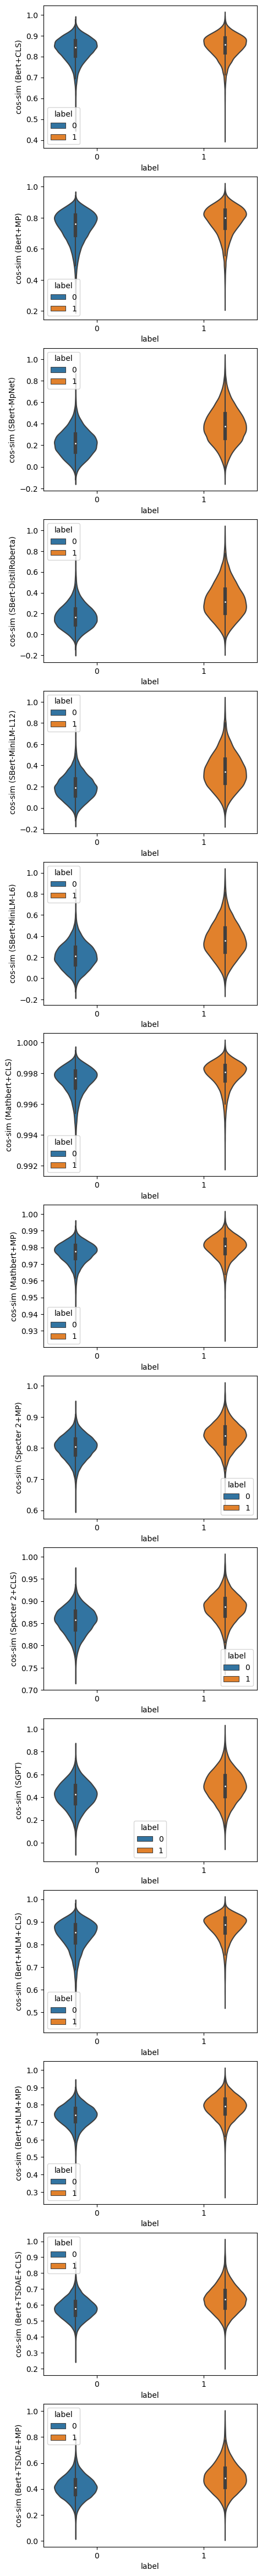

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
if len(eval_models) > 1:
    f, axs = plt.subplots(len(eval_models), 1, figsize=(5, 4*len(eval_models)))
    for i,n in enumerate(eval_models.keys()):
        sns.violinplot(X_test_score, x="label", y="cos-sim ({})".format(n), hue="label", ax=axs[i], scale="count", scale_hue=True)
else:
    for n in eval_models.keys():
        sns.violinplot(X_test_score, x="label", y="cos-sim ({})".format(n), hue="label", scale="count", scale_hue=True)

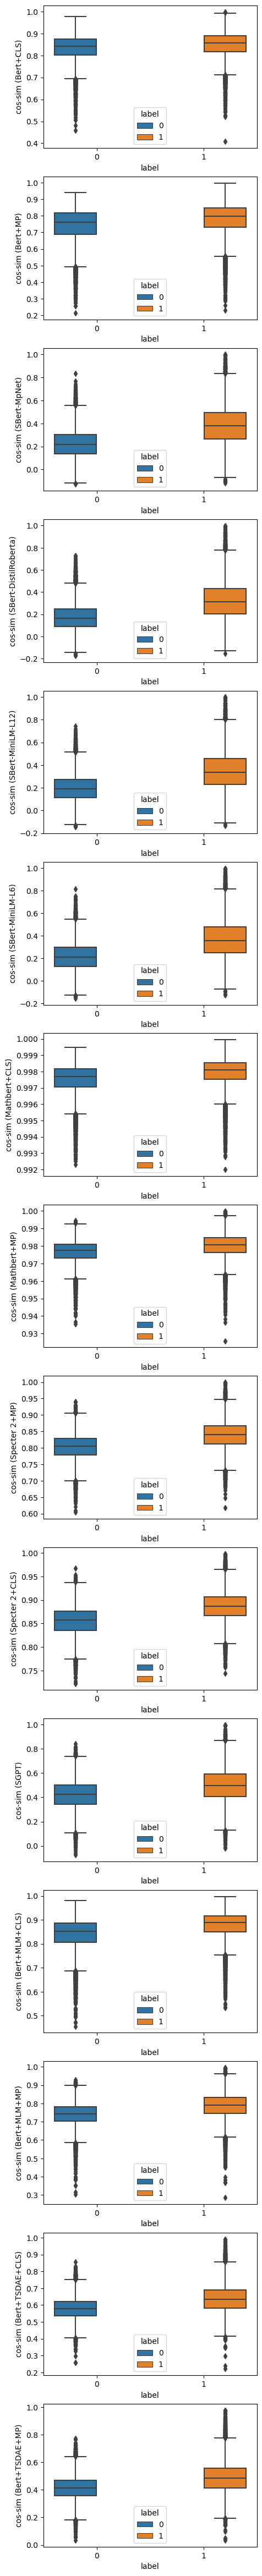

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axs = plt.subplots(len(eval_models), 1, figsize=(5, 4*len(eval_models)))
for i,n in enumerate(eval_models.keys()):
    sns.boxplot(X_test_score, x="label", y="cos-sim ({})".format(n), hue="label", ax=axs[i])

In [13]:
X_test_score[X_test_score["label"] == 1].describe()

,label,cos-sim (Bert+CLS),cos-sim (Bert+MP),cos-sim (SBert-MpNet),cos-sim (SBert-DistilRoberta),cos-sim (SBert-MiniLM-L12),cos-sim (SBert-MiniLM-L6),cos-sim (Mathbert+CLS),cos-sim (Mathbert+MP),cos-sim (Specter 2+MP),cos-sim (Specter 2+CLS),cos-sim (SGPT),cos-sim (Bert+MLM+CLS),cos-sim (Bert+MLM+MP),cos-sim (Bert+TSDAE+CLS),cos-sim (Bert+TSDAE+MP)
count,21860.0,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000
mean,1.0,0.849502,0.780535,0.383607,0.324935,0.348659,0.365894,0.997928,0.980079,0.839478,0.885723,0.497412,0.877916,0.786899,0.637732,0.489309
std,0.0,0.055747,0.095208,0.165431,0.167646,0.165718,0.166496,0.000882,0.006669,0.042040,0.030912,0.137069,0.053335,0.066821,0.082684,0.111075
min,1.0,0.407344,0.231708,-0.115505,-0.153225,-0.134946,-0.126114,0.991990,0.925813,0.617332,0.743926,-0.020413,0.533036,0.285846,0.220971,0.034789
25%,1.0,0.817983,0.731119,0.265080,0.203379,0.228767,0.248805,0.997517,0.976283,0.812606,0.866538,0.406008,0.850932,0.746333,0.580384,0.412761
50%,1.0,0.856832,0.798316,0.377412,0.311686,0.338174,0.355209,0.998091,0.980722,0.840285,0.886629,0.499402,0.887975,0.790974,0.634685,0.483126
75%,1.0,0.889156,0.848253,0.493199,0.433728,0.458172,0.475211,0.998532,0.984648,0.866924,0.906054,0.591069,0.915542,0.832620,0.690882,0.558385
max,1.0,0.998710,0.996165,0.998871,0.997575,0.998490,0.995432,0.999947,0.999858,0.998993,0.997904,0.996659,0.997600,0.994895,0.991519,0.975173


In [14]:
X_test_score[X_test_score["label"] == 0].describe()

,label,cos-sim (Bert+CLS),cos-sim (Bert+MP),cos-sim (SBert-MpNet),cos-sim (SBert-DistilRoberta),cos-sim (SBert-MiniLM-L12),cos-sim (SBert-MiniLM-L6),cos-sim (Mathbert+CLS),cos-sim (Mathbert+MP),cos-sim (Specter 2+MP),cos-sim (Specter 2+CLS),cos-sim (SGPT),cos-sim (Bert+MLM+CLS),cos-sim (Bert+MLM+MP),cos-sim (Bert+TSDAE+CLS),cos-sim (Bert+TSDAE+MP)
count,22075.0,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000
mean,0.0,0.835380,0.742679,0.223062,0.173319,0.196555,0.213424,0.997520,0.976737,0.802461,0.855399,0.421010,0.840775,0.739193,0.579163,0.414092
std,0.0,0.056621,0.099170,0.123818,0.115769,0.117554,0.122758,0.000925,0.006220,0.038430,0.030185,0.117395,0.064143,0.060888,0.065225,0.085898
min,0.0,0.458640,0.214445,-0.128904,-0.172969,-0.144833,-0.156140,0.992289,0.935480,0.604153,0.722603,-0.075009,0.456229,0.303859,0.257960,0.036158
25%,0.0,0.802699,0.686649,0.134587,0.089676,0.112809,0.125879,0.997062,0.973169,0.777637,0.835761,0.343811,0.807352,0.702476,0.534796,0.355894
50%,0.0,0.842908,0.760914,0.219247,0.165572,0.190601,0.208707,0.997699,0.977471,0.804560,0.857450,0.423954,0.852647,0.742748,0.577721,0.413101
75%,0.0,0.875774,0.815638,0.304003,0.246473,0.273145,0.294660,0.998162,0.981081,0.829066,0.876704,0.502342,0.887088,0.780924,0.621737,0.470578
max,0.0,0.976511,0.940576,0.835591,0.727130,0.744501,0.812297,0.999492,0.994470,0.940899,0.967199,0.844219,0.980097,0.929802,0.855053,0.773107


In [15]:
# Die Ergebnisse sehen schon sehr verdächtig aus, müssen wir ggf. Layer freezen? s. https://towardsdatascience.com/what-exactly-happens-when-we-fine-tune-bert-f5dc32885d76
X_test_score.sample(15, random_state=RANDOM_STATE)

,title_a,MSC_a,MSC2_a,title_b,MSC_b,MSC2_b,label,cos-sim (Bert+CLS),cos-sim (Bert+MP),cos-sim (SBert-MpNet),cos-sim (SBert-DistilRoberta),cos-sim (SBert-MiniLM-L12),cos-sim (SBert-MiniLM-L6),cos-sim (Mathbert+CLS),cos-sim (Mathbert+MP),cos-sim (Specter 2+MP),cos-sim (Specter 2+CLS),cos-sim (SGPT),cos-sim (Bert+MLM+CLS),cos-sim (Bert+MLM+MP),cos-sim (Bert+TSDAE+CLS),cos-sim (Bert+TSDAE+MP)
15960,Global exact quadratization of continuous-time...,93C10,"('93C15', '93A10', '34H05', '34H99', '34A34', ...",Mixed \(\mathcal{H}_2/\mathcal{H}_\infty\) con...,93E03,"('60J75', '93B36', '93C55', '93C05')",0,0.869027,0.714167,0.323349,0.256773,0.291546,0.356301,0.997982,0.977697,0.755879,0.864542,0.452031,0.913908,0.731365,0.655322,0.432630
186573,Edge operators with conditions of Toeplitz type,58J40,"('35S15', '47G30', '35A17', '35J70', '58J32')",A Bismut type theorem for subelliptic heat sem...,58J20,"('35H20', '47D06')",0,0.891898,0.829021,0.265826,0.169275,0.215530,0.334920,0.998733,0.983441,0.825373,0.866441,0.366333,0.868673,0.767364,0.606481,0.421135
181977,1-cohomology and splitting of group extensions,20E22,"('20J99', '20E07')",On some products of nilpotent groups,20E22,"('20F16', '20F18', '20E07', '20F14', '20H25')",1,0.770636,0.771517,0.318976,0.234555,0.299437,0.373915,0.998692,0.972540,0.826106,0.875071,0.239056,0.900380,0.759985,0.657363,0.512666
299961,Reputation in the long-run with imperfect moni...,91A20,"('91A05',)",Parallel repetition via fortification: analyti...,91A20,"('81P40', '81P45', '91A05', '91A06', '91A12', ...",1,0.801794,0.558969,0.117956,0.163015,0.100033,0.111946,0.997450,0.975870,0.750258,0.811901,0.397173,0.910455,0.721850,0.612747,0.442711
226982,Traces and quasi-traces on the Boutet de Monve...,58J42,"('35S15',)",The local and global parts of the basic zeta c...,58J42,"('35S15',)",1,0.886373,0.853275,0.324947,0.323028,0.189376,0.374181,0.995979,0.981029,0.810085,0.863069,0.459758,0.803558,0.742527,0.556919,0.406853
306772,A cyclic weight algorithm of decoding the \((4...,94B35,"('94B40',)",A result on the weight distributions of binary...,94B35,"('94B40',)",1,0.929209,0.846470,0.734946,0.745497,0.742028,0.687161,0.998392,0.987840,0.880253,0.920243,0.748491,0.864890,0.851190,0.794049,0.703549
205892,Properties of the Székely-Móri symmetry criter...,60E05,"('62E20', '62H10')",On deformation technique of the hyperbolic sec...,60E05,"('60E10', '62E17', '62E20')",1,0.863393,0.809938,0.171822,0.069898,0.255282,0.192040,0.998384,0.982728,0.833705,0.873919,0.440357,0.900060,0.802463,0.552621,0.376858
218358,Simultaneous visibility representations of pla...,05C62,"('05C10', '05C85', '68R10')",On the minimum order of graphs with given semi...,05C99,"('05C65', '20M30')",0,0.834144,0.815467,0.348301,0.245289,0.317085,0.317505,0.997415,0.976360,0.818668,0.853480,0.330873,0.926033,0.794927,0.586308,0.425695
77078,The unsteady MHD boundary-layer flow on a shri...,76W05,"('76N20', '76M45')",Meridional trapping and zonal propagation of i...,76U05,"('76B55', '86A05')",0,0.808860,0.758549,0.356288,0.277544,0.411113,0.350827,0.998697,0.985324,0.791738,0.841171,0.372482,0.911864,0.813748,0.647136,0.467020
63150,On unified contact metric manifold,53C15,"('53C25',)",Two characterizations of the Chern connection,53C10,"('53A55', '53B05', '58A20', '58A32')",0,0.810188,0.723980,0.392756,0.310528,0.324046,0.310901,0.998860,0.977408,0.776132,0.879987,0.395266,0.921439,0.725241,0.649392,0.530011
